In [18]:
import scipy

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, DepthwiseConv2D, ReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

## Generating label-file path data frame

In [20]:
from tensorflow.keras.layers import Layer, Add

In [21]:
data = r'D:\turantlo\Health Assistant\lung_colon_image_set'

path = []
labels = []

folders = os.listdir(data)

for folder in folders:
    folderpath = os.path.join(data, folder)
    sub_folders = os.listdir(folderpath)
    
    for sub_folder in sub_folders:
        sub_filepath = os.path.join(folderpath,sub_folder)
        files = os.listdir(sub_filepath)
        
        for file in files:
            file_path = os.path.join(sub_filepath, file)
            path.append(file_path)
            
            if sub_folder == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif sub_folder == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif sub_folder == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif sub_folder == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif sub_folder == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')
            
Fseries = pd.Series(path, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
df.sample(6)

filepaths  \
22269  D:\turantlo\Health Assistant\lung_colon_image_...   
2171   D:\turantlo\Health Assistant\lung_colon_image_...   
8555   D:\turantlo\Health Assistant\lung_colon_image_...   
9571   D:\turantlo\Health Assistant\lung_colon_image_...   
5176   D:\turantlo\Health Assistant\lung_colon_image_...   
6657   D:\turantlo\Health Assistant\lung_colon_image_...   

                             labels  
22269  Lung Squamous Cell Carcinoma  
2171           Colon Adenocarcinoma  
8555            Colon Benign Tissue  
9571            Colon Benign Tissue  
5176            Colon Benign Tissue  
6657            Colon Benign Tissue

## Split the data

Use 'stratify' to keep the proportion of classes same in each split

In [22]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

### Now read the images from the paths by making data generator

In [32]:
batch_size = 8
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


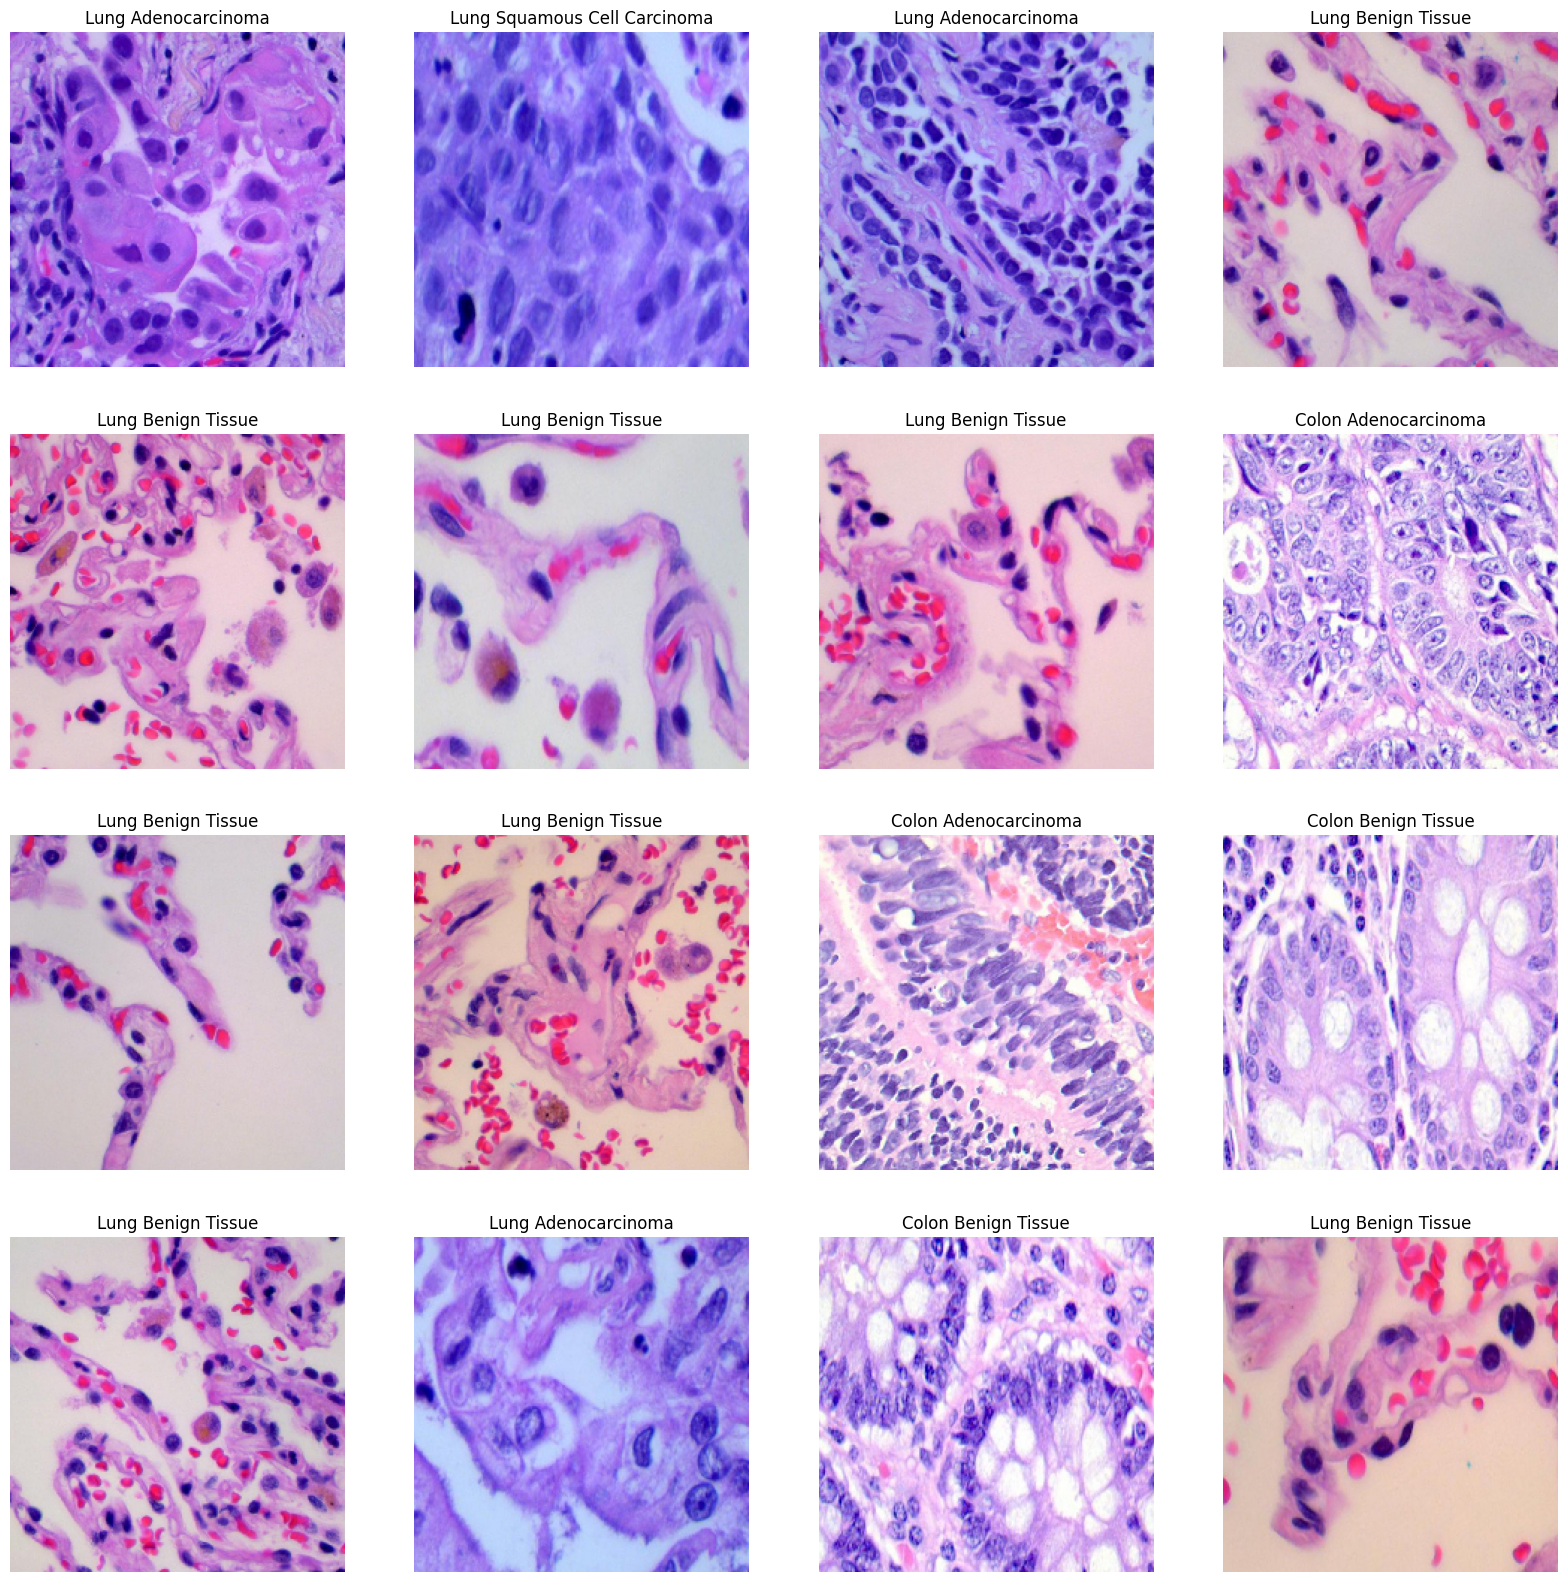

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# labels in one hot vector

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get the index of class
    plt.title(classes[index], fontsize= 12)
    plt.axis('off')
plt.show()

## Model

Try - 
- BatchNornm
- DeepthwiseConv2D
- Adam/Adamax
- Position of BatchNorm wrt activation function

In [15]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
classes = 5
p_drop = 0.3

model = Sequential([
    Conv2D(input_shape = img_shape, filters=64, kernel_size = (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    Conv2D(filters=64, kernel_size = (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=128, kernel_size = (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    Conv2D(filters=128, kernel_size = (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    Conv2D(filters=128, kernel_size = (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=256, kernel_size = (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    Conv2D(filters=256, kernel_size = (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    Conv2D(filters=256, kernel_size = (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=512, kernel_size = (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    Conv2D(filters=512, kernel_size = (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    Conv2D(filters=512, kernel_size = (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(p_drop),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(p_drop),
    Dense(classes, activation='softmax'),
    
])

In [16]:
model.compile(Adamax(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))
p_drop = 0.2

model2 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Dropout(p_drop),
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=64, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    Dropout(p_drop),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Dropout(p_drop),
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=128, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    Dropout(p_drop),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Dropout(p_drop),
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=256, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    Dropout(p_drop),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Dropout(p_drop),
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=512, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    Dropout(p_drop),
    
    Conv2D(filters=512, kernel_size=(1,1), padding="same", activation="relu"),
    Dropout(p_drop),
    MaxPooling2D((2, 2)),
    Conv2D(filters=512, kernel_size=(1,1), padding='same', activation="relu"),
    MaxPooling2D((2, 2)),
    Dropout(p_drop),
    
    Flatten(),
    Dense(128,activation = "relu"),
    Dropout(p_drop),
    Dense(64),
    BatchNormalization(),
    ReLU(),
    Dropout(p_drop),
    Dense(class_count, activation = "softmax")
])

In [9]:
model3.compile(Adamax(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model2.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 dropout (Dropout)           (None, 224, 224, 64)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 224, 224, 64)     640       
 Conv2D)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      4160      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 224, 224, 64)      0

In [15]:
import warnings
warnings.filterwarnings("ignore")
epochs = 20   # number of all epochs in training

history = model2.fit(x = train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
5000/5000 [==============================] - 984s 189ms/step - loss: 0.9830 - accuracy: 0.5727 - val_loss: 2.8205 - val_accuracy: 0.2000
Epoch 2/20
5000/5000 [==============================] - 969s 194ms/step - loss: 0.6717 - accuracy: 0.7375 - val_loss: 2.9351 - val_accuracy: 0.2000
Epoch 3/20
5000/5000 [==============================] - 1016s 203ms/step - loss: 0.5349 - accuracy: 0.8056 - val_loss: 2.1855 - val_accuracy: 0.2132
Epoch 4/20
5000/5000 [==============================] - 1055s 211ms/step - loss: 0.4387 - accuracy: 0.8440 - val_loss: 1.6217 - val_accuracy: 0.3860
Epoch 5/20
5000/5000 [==============================] - 1255s 251ms/step - loss: 0.3661 - accuracy: 0.8728 - val_loss: 1.4755 - val_accuracy: 0.4524
Epoch 6/20
5000/5000 [==============================] - 1253s 250ms/step - loss: 0.3050 - accuracy: 0.8961 - val_loss: 2.6072 - val_accuracy: 0.3748
Epoch 7/20
5000/5000 [==============================] - 1085s 217ms/step - loss: 0.2623 - accuracy: 0.9137 -

In [24]:
class ResidualBlock(Layer):
    def __init__(self, filters, kernel_size=3, stride=1, padding='same'):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding)
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        self.conv2 = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')
        self.bn2 = BatchNormalization()
        self.add = Add()
        self.relu2 = ReLU()

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        
        x = self.add([x, input_tensor])
        x = self.relu2(x)
        return x

In [29]:
# Create Model Structure
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))
p_drop = 0.2

model3 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
#     Dropout(p_drop),
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=64, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    ResidualBlock(filters=64),
#     Dropout(p_drop),
    ResidualBlock(filters=64),
#     Dropout(p_drop),
    
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=128, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    ResidualBlock(filters=128),
    Dropout(p_drop),
    ResidualBlock(filters=128),
#     Dropout(p_drop),
    
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=256, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    Dropout(p_drop),
    MaxPooling2D((2, 2)),
    ResidualBlock(filters=256),
    Dropout(p_drop),
    
    DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=512, kernel_size=(1,1), padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),
    ResidualBlock(filters=512),
    Dropout(p_drop),
#     DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation="relu"),
#     Conv2D(filters=512, kernel_size=(1,1), padding="same"),
#     BatchNormalization(),
#     ReLU(),
#     Dropout(p_drop),
    MaxPooling2D((2, 2)),
    ResidualBlock(filters=512),
#     Dropout(p_drop),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256,activation = "relu"),
    Dropout(p_drop),
    Dense(128,activation = "relu"),
    Dropout(p_drop),
    Dense(64,activation = "relu"),
    Dropout(p_drop),
    Dense(16),
    BatchNormalization(),
    ReLU(),
    Dropout(p_drop),
    Dense(class_count, activation = "softmax")
])

In [30]:
model3.compile(Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 depthwise_conv2d_10 (Depthw  (None, 128, 128, 64)     640       
 iseConv2D)                                                      
                                                                 
 conv2d_47 (Conv2D)          (None, 128, 128, 64)      4160      
                                                                 
 batch_normalization_40 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_40 (ReLU)             (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 64, 64)      

In [33]:
epochs = 20   # number of all epochs in training
history = model3.fit(x = train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
2500/2500 [==============================] - 836s 331ms/step - loss: 0.3370 - accuracy: 0.9420 - val_loss: 1.0880 - val_accuracy: 0.5944
Epoch 2/20
2500/2500 [==============================] - 803s 321ms/step - loss: 0.3138 - accuracy: 0.9474 - val_loss: 0.9176 - val_accuracy: 0.6360
Epoch 3/20
2500/2500 [==============================] - 701s 280ms/step - loss: 0.2899 - accuracy: 0.9545 - val_loss: 1.3742 - val_accuracy: 0.3992
Epoch 4/20
2500/2500 [==============================] - 708s 283ms/step - loss: 0.2629 - accuracy: 0.9585 - val_loss: 1.2685 - val_accuracy: 0.4788
Epoch 5/20
2500/2500 [==============================] - 730s 292ms/step - loss: 0.2466 - accuracy: 0.9603 - val_loss: 1.0447 - val_accuracy: 0.5688
Epoch 6/20
2500/2500 [==============================] - 691s 276ms/step - loss: 0.2273 - accuracy: 0.9652 - val_loss: 0.8101 - val_accuracy: 0.7456
Epoch 7/20
2500/2500 [==============================] - 648s 259ms/step - loss: 0.2108 - accuracy: 0.9690 - val_

KeyboardInterrupt: 

In [34]:
model3.save_weights('model3.h5')

In [36]:
import shutil

model_path = 'weights_0.3_Adamax.weights.h5'
model.save_weights(model_path)
shutil.move(model_path, '/kaggle/working/weights_0.3_Adamax.weights.h5')

'/kaggle/working/weights_0.3.weights.h5'

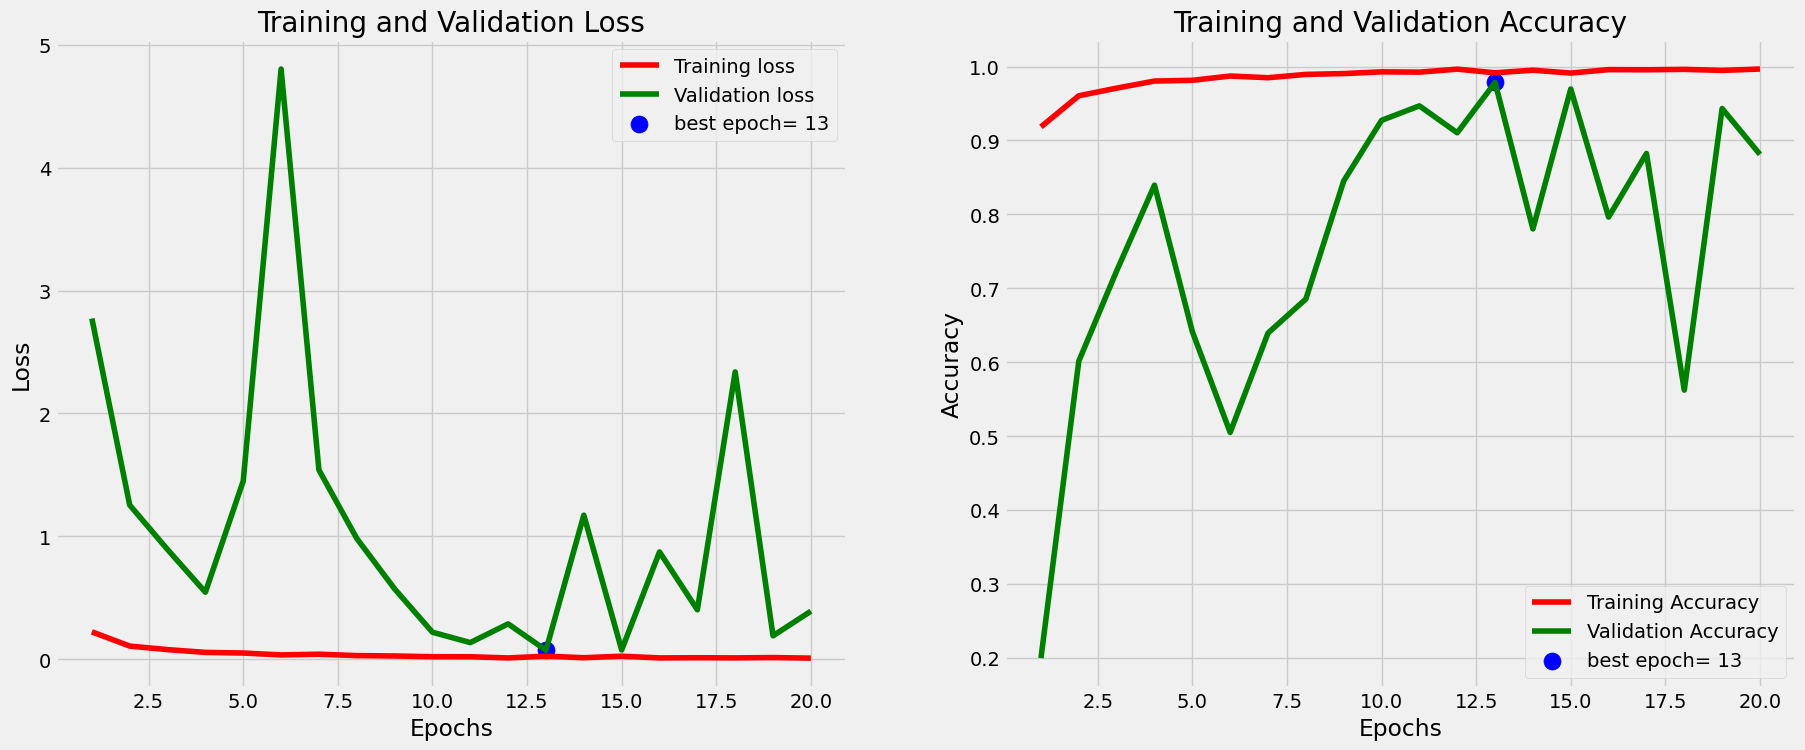

In [31]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [32]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - accuracy: 0.7064 - loss: 2.4816
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 359ms/step - accuracy: 0.6959 - loss: 2.6398
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step - accuracy: 0.6989 - loss: 2.6377
Train Loss:  2.5604686737060547
Train Accuracy:  0.699999988079071
--------------------
Valid Loss:  2.755634069442749
Valid Accuracy:  0.701200008392334
--------------------
Test Loss:  2.933797836303711
Test Accuracy:  0.7024000287055969


In [39]:
def multiclass_calibration_curve(probs, labels, bins=10):
    step_size = 1.0 / bins
    n_classes = probs.shape[1]
#     labels_ohe = np.eye(n_classes)[labels.astype(np.int64)]
    labels_ohe = labels
    midpoints = []
    mean_confidences = []
    accuracies = []
    ece = []
    for i in range(bins):
        beg = i * step_size
        end = (i + 1) * step_size

        bin_mask = (probs >= beg) & (probs < end)
        bin_cnt = bin_mask.astype(np.float32).sum()
        bin_confs = probs[bin_mask]
        bin_acc = labels_ohe[bin_mask].sum() / bin_cnt

        midpoints.append((beg+end)/2.)
        mean_confidences.append(np.mean(bin_confs))
        accuracies.append(bin_acc)
        ece.append(bin_cnt*np.abs(mean_confidences[-1] - accuracies[-1]))
    return midpoints, accuracies, mean_confidences, ece

In [40]:
def plot_multiclass_calibration_curve(probs, labels, bins=10, title=None):
    title = 'Reliability Diagram' if title is None else title
    midpoints, accuracies, mean_confidences, ece = multiclass_calibration_curve(probs, labels, bins=bins)
    plt.bar(midpoints, accuracies, width=1.0/float(bins), align='center', lw=1, ec='#000000', fc='#2233aa', alpha=1, label='Model', zorder=0)
    plt.scatter(midpoints, accuracies, lw=2, ec='black', fc="#ffffff", zorder=2)
    plt.plot(np.linspace(0, 1.0, 20), np.linspace(0, 1.0, 20), '--', lw=2, alpha=.7, color='gray', label='Perfectly calibrated', zorder=1)
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel('\nconfidence')
    plt.ylabel('accuracy\n')
    plt.title(title+'\n')
    plt.xticks(midpoints, rotation=-45)
    plt.legend(loc='upper left')
    ece = np.array(ece).sum()/100
    return midpoints, accuracies, mean_confidences, ece

In [35]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen1 = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen1 = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen1 = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [37]:
images, labels = next(test_gen1)
probs = model(images).numpy()

In [42]:
probs = model(images).numpy()

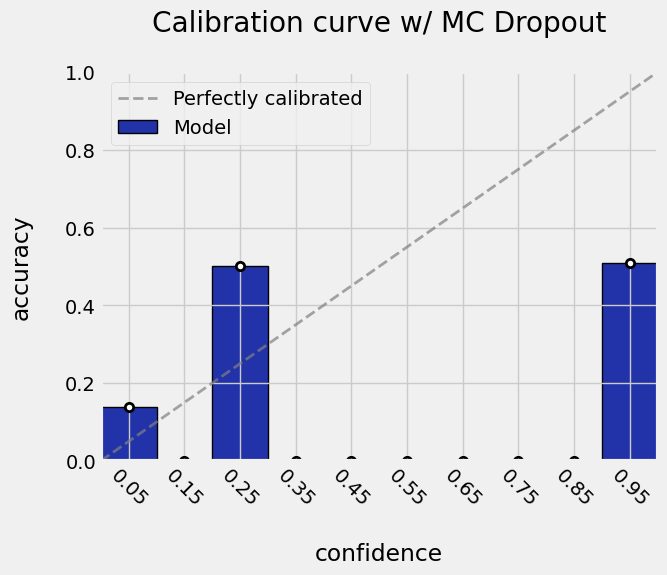

In [43]:
midpoints, accuracies, mean_confidences, ece_mc = plot_multiclass_calibration_curve(probs, labels, bins=10, title='Calibration curve w/ MC Dropout')

In [57]:
images, labels = next(test_gen1)

In [58]:
model(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.00237234, 0.        , 0.        , 0.        , 0.9976277 ]],
      dtype=float32)

In [60]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

 2/40 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step

W0000 00:00:1722106107.419349     197 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 322ms/step


W0000 00:00:1722106119.993618     199 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


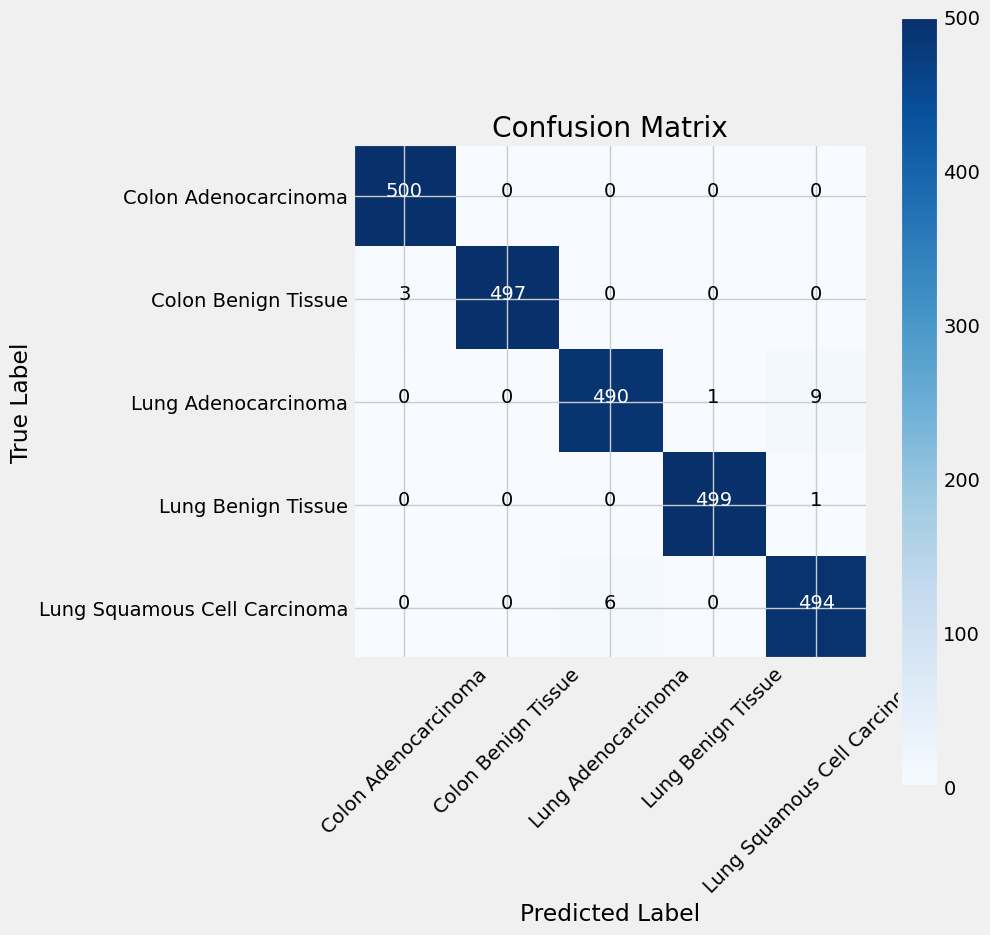

In [65]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [66]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.99      1.00      1.00       500
         Colon Benign Tissue       1.00      0.99      1.00       500
         Lung Adenocarcinoma       0.99      0.98      0.98       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.98      0.99      0.98       500

                    accuracy                           0.99      2500
                   macro avg       0.99      0.99      0.99      2500
                weighted avg       0.99      0.99      0.99      2500

